# Forecasting monthly turnover of the Other Retailing Industry in New South Wales using ARIMA models

In [1]:
#Run library
library(fpp3)
library(readr)
library(readxl)

── Attaching packages ────────────────────────────────────────────── fpp3 0.5 ──

✔ tibble      3.2.1     ✔ tsibble     1.1.3
✔ dplyr       1.1.2     ✔ tsibbledata 0.4.1
✔ tidyr       1.3.0     ✔ feasts      0.3.1
✔ lubridate   1.9.2     ✔ fable       0.3.3
✔ ggplot2     3.4.2     ✔ fabletools  0.3.3

── Conflicts ───────────────────────────────────────────────── fpp3_conflicts ──
✖ lubridate::date()    masks base::date()
✖ dplyr::filter()      masks stats::filter()
✖ tsibble::intersect() masks base::intersect()
✖ tsibble::interval()  masks lubridate::interval()
✖ dplyr::lag()         masks stats::lag()
✖ tsibble::setdiff()   masks base::setdiff()
✖ tsibble::union()     masks base::union()



In [2]:
#load data 
data <- read_csv("/kaggle/input/historical-data-of-monthly-turnover-in-aus/historical_data_AUS.csv")
meta <- read_csv("/kaggle/input/historical-data-of-monthly-turnover-in-aus/historical_data_AUS.csv", col_names = TRUE, n_max = 3)
dat <- read_csv("/kaggle/input/historical-data-of-monthly-turnover-in-aus/historical_data_AUS.csv", 
                col_names = colnames(meta),
                skip = 4)
my_series <- dat %>% 
  rename(Month = "M", y ="Turnover") %>%
  select(Month, y) %>% 
  mutate(Month=yearmonth(Month)) %>% 
  as_tsibble(index = Month)

Rows: 468 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): M, Turnover

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 3 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): M, Turnover

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 465 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): M
dbl (1): Turnover

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [3]:
head(my_series)

#train dataset 
train <- my_series %>% 
  slice(1:(n() - 24))

#test dataset (last 2 years)
test <- my_series %>%
  slice((n() - 23):n())

Month,y
<mth>,<dbl>
1982 Apr,178.0
1982 May,181.5
1982 Jun,174.1
1982 Jul,180.2
1982 Aug,178.1
1982 Sep,176.5


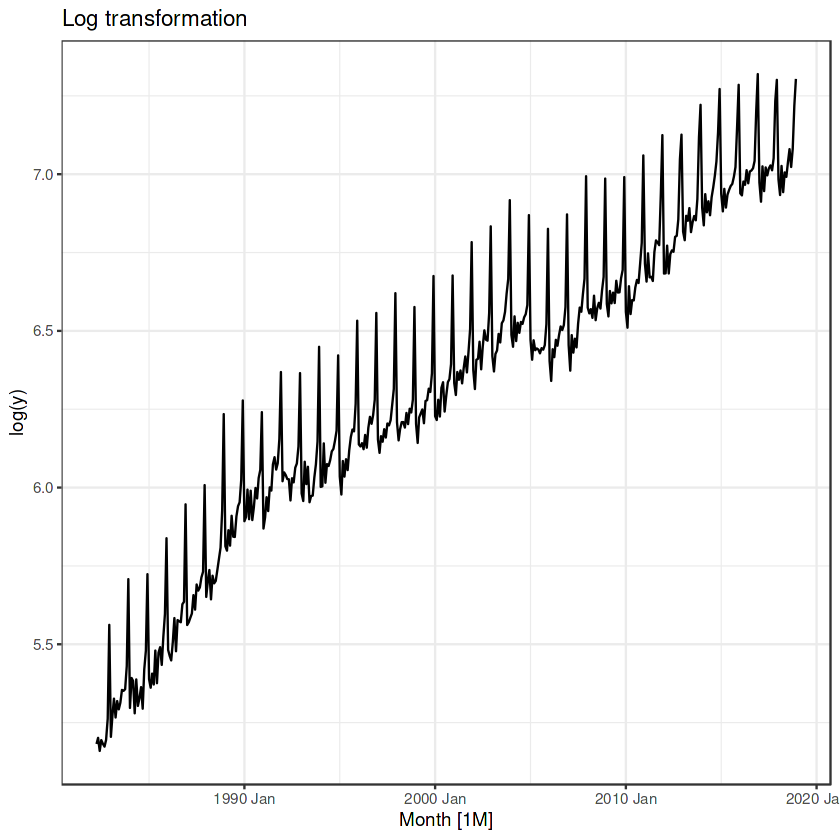

In [4]:
#conduct log transformation 
train %>% autoplot(log(y)) + 
  labs(title = "Log transformation", y = "log(y)") + theme_bw() 

Warning message:
“Removed 13 rows containing missing values (`geom_line()`).”
Warning message:
“Removed 13 rows containing missing values (`geom_point()`).”


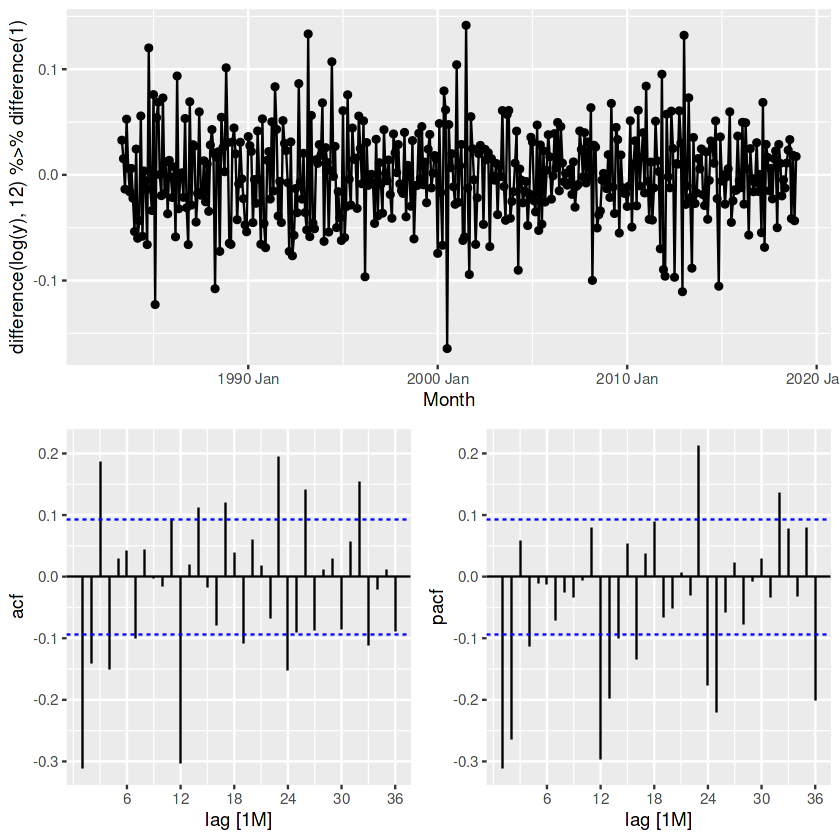

In [5]:
#Conduct Stationary Test
train %>% 
  gg_tsdisplay(difference(log(y), 12) %>%  difference(1), plot_type = 'partial', lag = 36)

In [6]:
#choose the ARIMA model manually
manual_fit <- train %>% 
  model(ARIMA_manual = ARIMA(log(y) ~ 0 + pdq(4,1,0) + PDQ(3,1,0)))

report(manual_fit)

Series: y 
Model: ARIMA(4,1,0)(3,1,0)[12] 
Transformation: log(y) 

Coefficients:
          ar1      ar2     ar3      ar4     sar1     sar2     sar3
      -0.4538  -0.3002  0.0133  -0.1272  -0.5811  -0.4671  -0.2897
s.e.   0.0490   0.0531  0.0535   0.0483   0.0482   0.0512   0.0481

sigma^2 estimated as 0.001091:  log likelihood=852.07
AIC=-1688.14   AICc=-1687.8   BIC=-1655.67


.model,lb_stat,lb_pvalue
<chr>,<dbl>,<dbl>
ARIMA_manual,27.50605,0.0510513


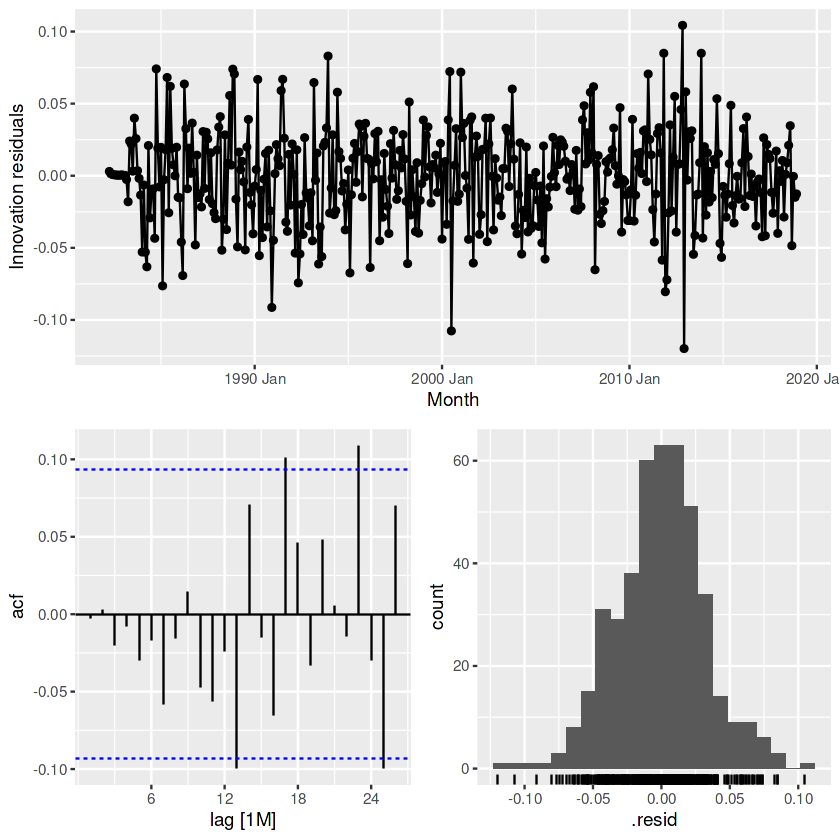

In [7]:
#check ARIMA_manual model ACF
manual_fit %>% 
  gg_tsresiduals() 

#ljung text
augment(manual_fit) %>% 
  features(.innov, ljung_box, lag = 24, dof = 7) 

The residuals seem centered around zero and the histogram is symmetrical. However, there are 4 significant spikes exceeding limits, suggesting there is autocorrelation not captured in the model. The p-value is more than 0.05, null hypothesis is accepted and data is white noise and suitable for forecasting.

In [8]:
#Choose alternative manual ARIMA model and make comparison
multimanual_fit <- train %>% 
  model(ARIMA_manual = ARIMA(log(y) ~ 0 + pdq(4,1,0) + PDQ(3,1,0)),
        ARIMA_manual_1 = ARIMA(log(y) ~ 0 + pdq(3,1,0) + PDQ(3,1,0)),
        ARIMA_manual_2 = ARIMA(log(y) ~ 0 + pdq(4,1,0) + PDQ(0,1,3)),
        ARIMA_manual_3 = ARIMA(log(y) ~ 0 + pdq(3,1,0) + PDQ(0,1,3))
)

#arrange order
multimanual_fit %>% pivot_longer(everything(), names_to = "Model name",
                     values_to = "Orders")

Warning message in log(s2):
“NaNs produced”
Warning message:
“1 error encountered for ARIMA_manual_1
[1] non-finite finite-difference value [3]
”


Model name,Orders
<chr>,<model>
ARIMA_manual,"<ARIMA(4,1,0)(3,1,0)[12]>"
ARIMA_manual_1,<NULL model>
ARIMA_manual_2,"<ARIMA(4,1,0)(0,1,3)[12]>"
ARIMA_manual_3,"<ARIMA(3,1,0)(0,1,3)[12]>"


In [9]:
#show best manual model based on AICc
glance(multimanual_fit) %>% arrange(AICc) %>%  select(.model:BIC) 

.model,sigma2,log_lik,AIC,AICc,BIC
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ARIMA_manual,0.001090573,852.0703,-1688.141,-1687.797,-1655.668
ARIMA_manual_2,0.001090667,851.9259,-1687.852,-1687.508,-1655.379
ARIMA_manual_3,0.001103679,848.8044,-1683.609,-1683.342,-1655.195


Based on AICc, ARIMA_manual, ARIMA(4,1,0)(3,1,0) is the best model out of the 4 chosen model and it proves that I have selected the best AR and MA terms for my ARIMA model.

In [10]:
#Auto Select Model
fit_best <- train %>% 
  model(auto_best = ARIMA(log(y),
                          stepwise = FALSE, approximation = FALSE,
                          order_constraint = p + q +P + Q <= 9)) 
#put order constraint to limit complexity of model and prevent over fitting

Warning message:
“Model specification induces a quadratic or higher order polynomial trend. 
This is generally discouraged, consider removing the constant or reducing the number of differences.”


In [11]:
#Compare models and conduct test to choose ARIMA model for forecasting

crossfit <- fit_best %>% cross_join(multimanual_fit)

#arrange order
crossfit %>% pivot_longer(everything(), names_to = "Model name",
                     values_to = "Orders")


Model name,Orders
<chr>,<model>
auto_best,"<ARIMA(3,1,2)(2,1,1)[12]>"
ARIMA_manual,"<ARIMA(4,1,0)(3,1,0)[12]>"
ARIMA_manual_1,<NULL model>
ARIMA_manual_2,"<ARIMA(4,1,0)(0,1,3)[12]>"
ARIMA_manual_3,"<ARIMA(3,1,0)(0,1,3)[12]>"


In [12]:
#Compare AICc value
glance(crossfit) %>% arrange(AICc) %>%  select(.model:BIC) 

#compare test set accuracy 
crossfit %>% 
  forecast(h = 24) %>% 
  accuracy(my_series) %>% 
   select(.model, .type, MAE, RMSE, MAPE) %>% 
  arrange(RMSE)

.model,sigma2,log_lik,AIC,AICc,BIC
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
auto_best,0.001080600,854.2613,-1690.523,-1690.092,-1653.991
ARIMA_manual,0.001090573,852.0703,-1688.141,-1687.797,-1655.668
ARIMA_manual_2,0.001090667,851.9259,-1687.852,-1687.508,-1655.379
ARIMA_manual_3,0.001103679,848.8044,-1683.609,-1683.342,-1655.195


.model,.type,MAE,RMSE,MAPE
<chr>,<chr>,<dbl>,<dbl>,<dbl>
auto_best,Test,50.08329,74.86212,3.672230
ARIMA_manual_2,Test,54.78734,84.66440,3.993760
ARIMA_manual_3,Test,58.60062,88.82460,4.290431
ARIMA_manual,Test,62.08238,95.38029,4.519823
ARIMA_manual_1,Test,NaN,NaN,NaN


**The Best Model is Selected**

The test dataset consists of the last 2 years of data. Since all models have the same differencing. Auto_best model, ARIMA(3,1,2)(2,1,1) was selected as the best model based on lowest AICc value. Additionally, this model ranked first based on RMSE and other accuracy metrics.

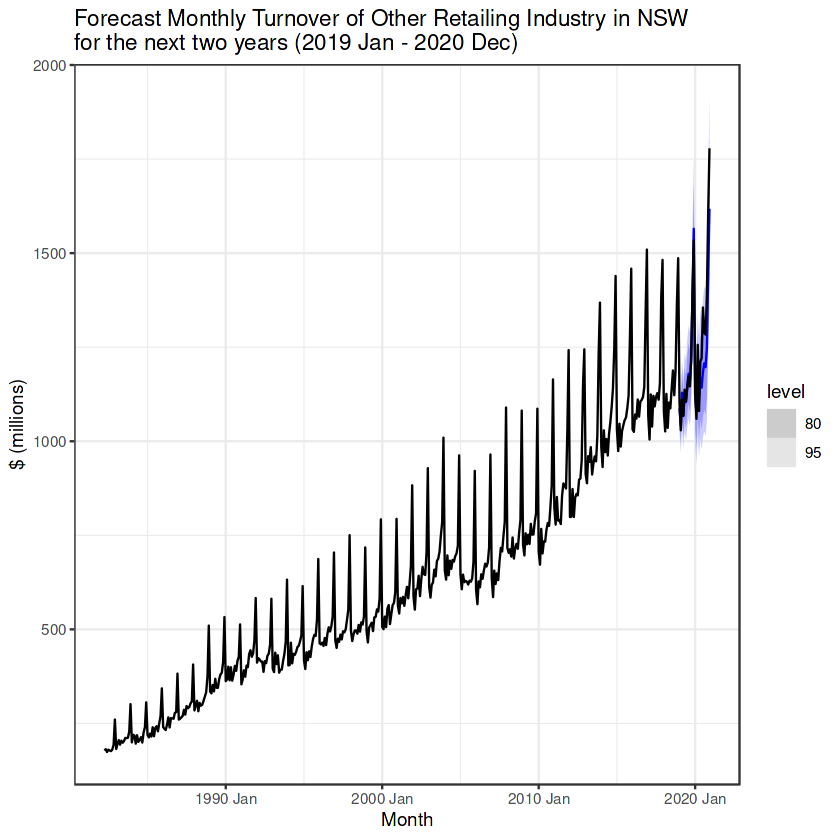

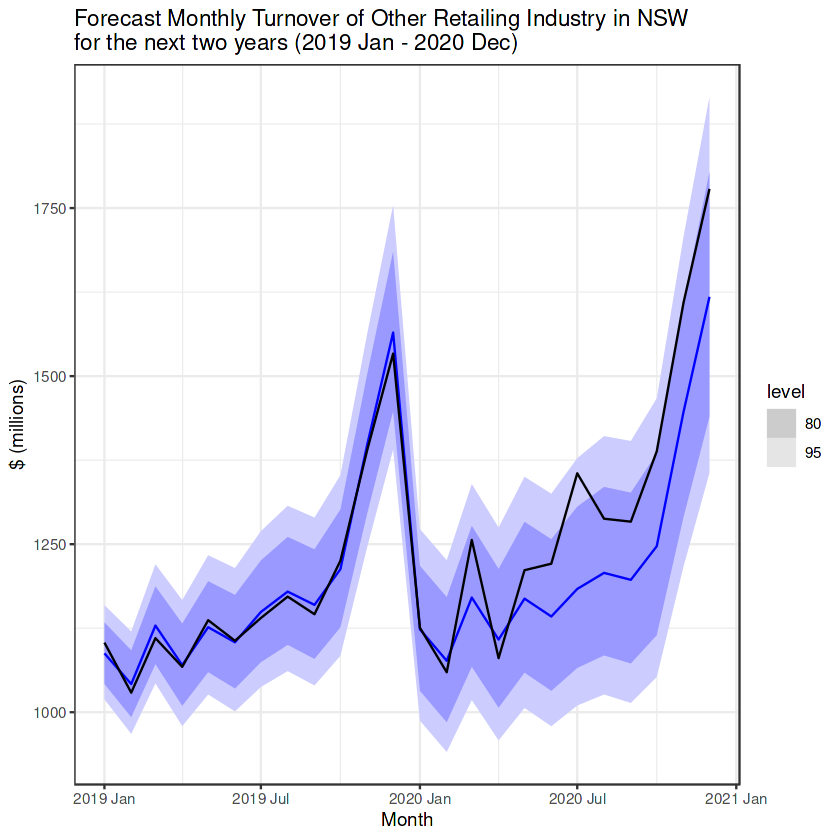

In [13]:
#Generate plot forecast and forecast intervals from chosen ARIMA models 
train %>% 
  model(ARIMA(log(y) ~ 0 + pdq(3,1,2) + PDQ(2,1,1))) %>%  #auto select model by R 
  forecast(h = 24) %>% 
  autoplot(my_series) + labs(title = "Forecast Monthly Turnover of Other Retailing Industry in NSW\nfor the next two years (2019 Jan - 2020 Dec)",
       y =  "$ (millions)") + theme_bw()

#zoom in the last 2 years of forecast
train %>% 
  model(ARIMA(log(y) ~ 0 + pdq(3,1,2) + PDQ(2,1,1))) %>% 
  forecast(h = 24) %>% 
  autoplot(test) + labs(title = "Forecast Monthly Turnover of Other Retailing Industry in NSW\nfor the next two years (2019 Jan - 2020 Dec)",
       y =  "$ (millions)") + theme_bw()

**The forecast output from best ARIMA model**

The chosen ARIMA model provides reasonable point forecasts as values look highly identical to previous data as the model captures the of trend and seasonality.

The forecast intervals look reasonable too as prediction intervals become wider in 2020 and the forecast mostly fails within the 80% confidence interval.

## Compare forecast with new real data till Mar 2023 

In [14]:
#load data 
new_data_date <- read_excel("/kaggle/input/8501011/8501011.xlsx", sheet = "Data1", skip = 9, range = "A1:A502", col_types = "date")

#load the remaining columns without specifying col_types
new_data_rest <- read_excel("/kaggle/input/8501011/8501011.xlsx", sheet = "Data1", skip = 9, range = "B1:GH502")

# Combine the date column and remove the necessary rows
new_data <- cbind(new_data_date, new_data_rest) %>% slice(-(1:9))

updated_series <- new_data %>% 
  rename(Month = "Month", y ="Turnover ;  New South Wales ;  Other retailing ;") %>%
  select(Month, y) %>% 
  mutate(Month=yearmonth(Month)) %>% 
  as_tsibble(index = Month)

updated_series <- updated_series %>%
  mutate(y = as.numeric(y))



Warning message:
“Expecting date in A2 / R2C1: got 'Unit'”
Warning message:
“Expecting date in A3 / R3C1: got 'Series Type'”
Warning message:
“Expecting date in A4 / R4C1: got 'Data Type'”
Warning message:
“Expecting date in A5 / R5C1: got 'Frequency'”
Warning message:
“Expecting date in A6 / R6C1: got 'Collection Month'”
Warning message:
“Expecting date in A7 / R7C1: got 'Series Start'”
Warning message:
“Expecting date in A8 / R8C1: got 'Series End'”
Warning message:
“Expecting date in A9 / R9C1: got 'No. Obs'”
Warning message:
“Expecting date in A10 / R10C1: got 'Series ID'”


In [15]:
updated_series %>% tail(12) #check the value of updates series

Month,y
<mth>,<dbl>
2022 Apr,1507.3
2022 May,1606.3
2022 Jun,1593.5
2022 Jul,1610.9
2022 Aug,1614.4
2022 Sep,1616.6
2022 Oct,1659.3
2022 Nov,1898.3
2022 Dec,2081.3


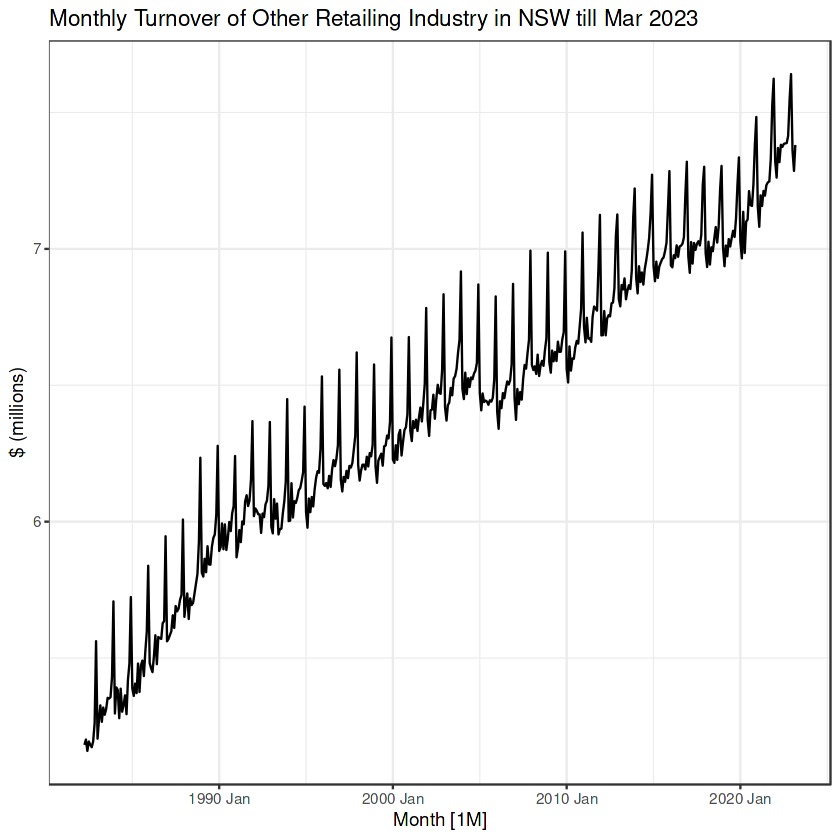

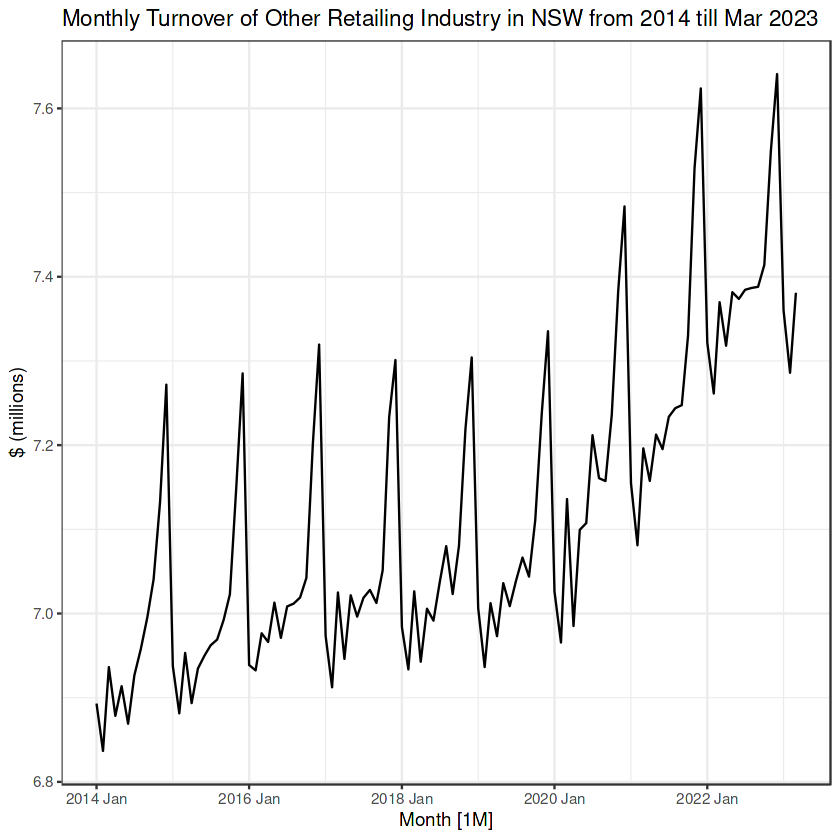

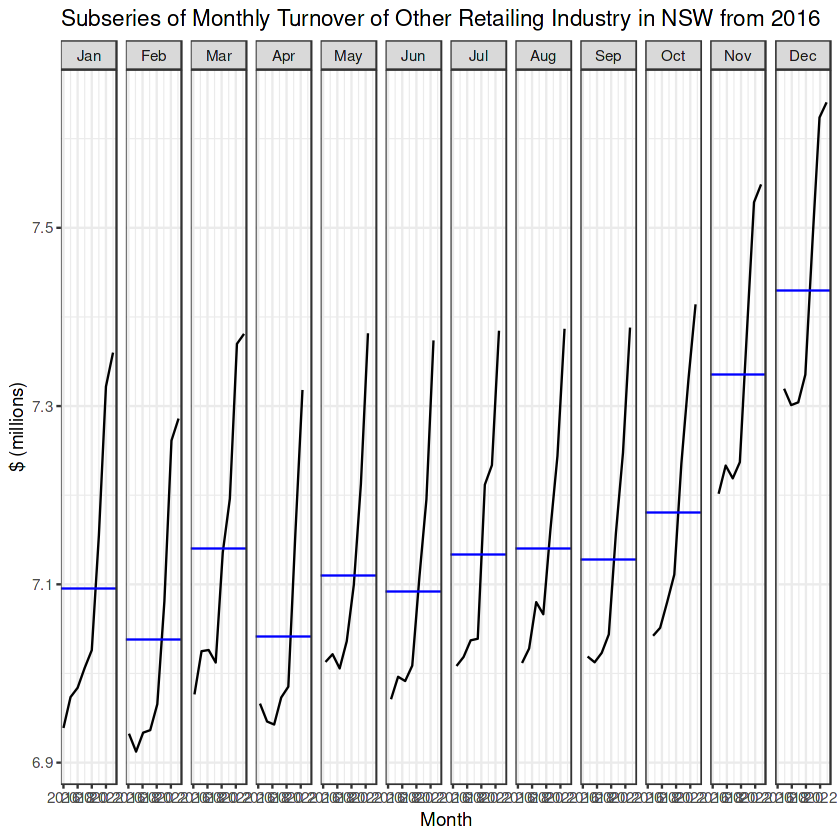

In [16]:
#plot updated time series
updated_series %>% autoplot(log(y)) +
  labs(title = "Monthly Turnover of Other Retailing Industry in NSW till Mar 2023", y =  "$ (millions)") + theme_bw()

#(WHO) declared the (COVID-19) a worldwide pandemic on 11 March 2020
updated_series %>%
  filter(year(Month) >= 2014) %>%
  autoplot(log(y)) +
  labs(title = "Monthly Turnover of Other Retailing Industry in NSW from 2014 till Mar 2023", y = "$ (millions)") +
  theme_bw()

#the monthly turnover performance in each month from 2016 til Mar 2023
updated_series %>%  
   filter(year(Month) >= 2016) %>% gg_subseries(log(y)) +
  labs(title = "Subseries of Monthly Turnover of Other Retailing Industry in NSW from 2016", 
       y =  "$ (millions)") + theme_bw()

The latest time series data shows that the monthly turnover of the Other Retailing Industry in NSW performed well during the COVID-19 pandemic. The high spikes in March and July 2020 and in December 2020, 2021 and 2022 shows an even higher turnover compared to the pre-COVID years, suggesting a positive impact on the industry during that period.

Additionally, the overall growth of the industry during the pandemic is evident as the monthly turnover increased at a faster rate than the original trend. This observation is further supported by the subseries plot, which shows a steeper upward trend across all months during the COVID-19 pandemic. Nevertheless, the trend become slightly dampened during the covid recover period.

The positive performance can be attributed to the composition of the Other Retailing Industry, which includes e-commerce and second-hand goods retailing. These sectors experienced a boom and benefited from the COVID-19 pandemic as consumer behavior shifted towards online shopping and increased demand for second-hand goods.

## Compare forecast results using ARIMA models, ETS models and SNAIVE as benchmark 

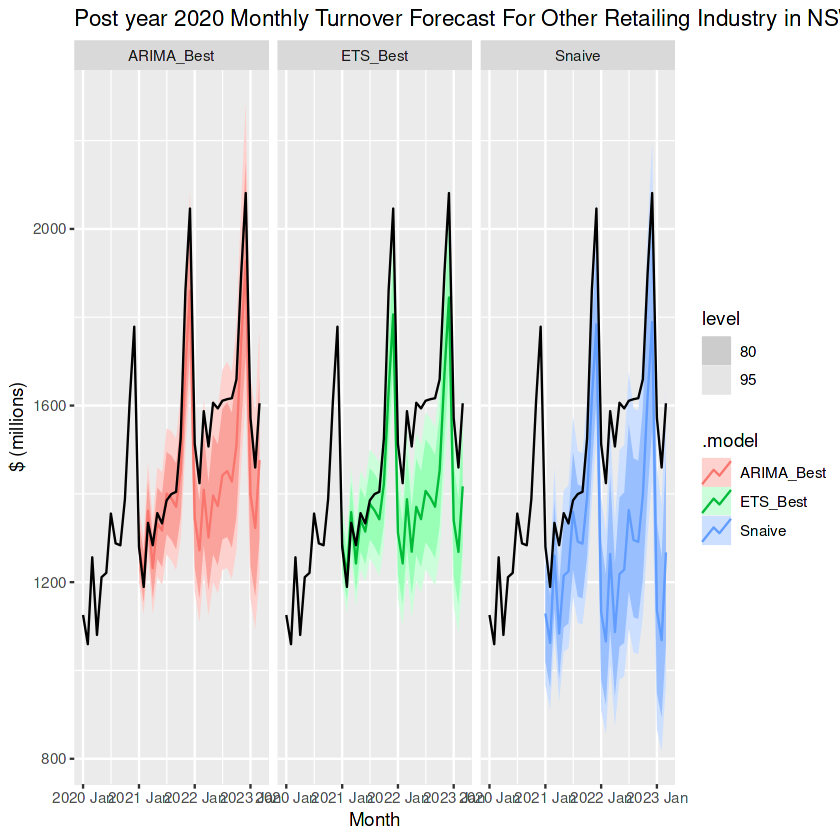

In [17]:
#Obtain the forecasts accuracy for period from 2020 until Mar 2023

#benchmark
#ETS Model
#ARIMA Model

#train dataset (pre 2020)
updated_train <- updated_series %>% 
  slice(1:(n() - 27))

#test dataset (post 2020)
updated_test <- updated_series %>%
  slice((n() - 26):n())

all_fit_train <- updated_train %>% 
  model('ETS_Best' = ETS(y ~ error("M") + trend("A") + season("M")), 
        'ARIMA_Best' = ARIMA(log(y) ~ 0 + pdq(3,1,2) + PDQ(2,1,1)),
        'Snaive' = SNAIVE(log(y)))

all_fit_train_forecast <- all_fit_train %>% 
  forecast(h = 27) 
  
all_fit_train_forecast %>% 
  autoplot(filter(updated_series, year(Month) >= 2020)) +
  labs(title = "Post year 2020 Monthly Turnover Forecast For Other Retailing Industry in NSW",
       y = "$ (millions)") +
  facet_wrap(~ .model)

**Conclusion**

The SNAIVE model's forecast performed the worst against the actual values after 2020, as most of the actual values fell at the edge or beyond the 95% prediction interval.

The ETS (M, A, M) forecast performed better than the SNAIVE model, especially till October 2021, however, after October 2021, the actual value starts to fell outside the 95% prediction interval or at the edge of the 95% confidence interval. 

The point forecast and prediction interval of the ARIMA(3,1,2)(2,1,1) model performed the best among all three models. The actual values have been within the confidence interval for the entire forecast period and even within the 80% confidence interval most of the time. 

It is evident that the ETS and SNAIVE models did not fully account for the impact of the Covid-19 pandemic on the monthly turnover for the Other Retailing Industry.